In [3]:
import os
import sys
import time
import struct
import glob
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

import libMaker as lm

In [4]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('data/spectra.npy')
wl = np.load('data/wl.npy')
genus = np.load('data/genus.npy')
species = np.load('data/species.npy')
principle_part = np.load('data/principle_part.npy')
health = np.load('data/health.npy')
growth_stage = np.load('data/growth_stage.npy')
DateTimeId = np.load('data/DateTimeId.npy')
month = np.load('data/month.npy')
name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
name_genus_species = np.load('data/name_genus_species.npy')# the genus and species if known - otherwise NA
name_full_category = np.load('data/name_full_category.npy')# all the metadata available in one string
plant_type = np.load('data/plant_type.npy')# the type of plant (tree, shrub, grass, etc.) - otherwise NA

nSpec = spectra.shape[0]
nBands = spectra.shape[1]
print(f'Min wavelength: {np.min(wl)}')
print(f'Max wavelength: {np.max(wl)}')
print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')

Min wavelength: 350.0
Max wavelength: 2500.0
Number of Spectra: 1020
Number of Bands: 2151


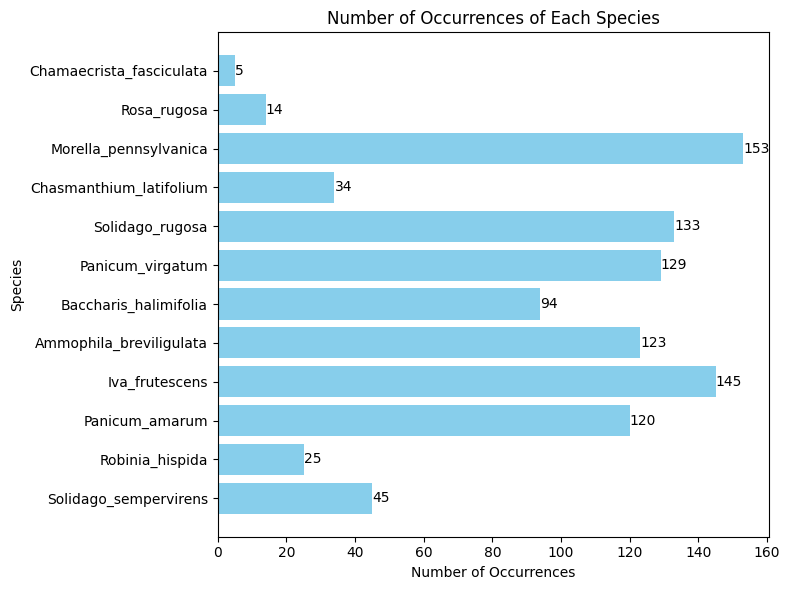

In [5]:
# Count the occurrences of each unique value
name_counts = Counter(name)

#print(name_counts.items())
#print(*name_counts.items())

# Extract the labels and values
labels, values = zip(*name_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, values, color='skyblue')
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species')
plt.tight_layout()
plt.show()

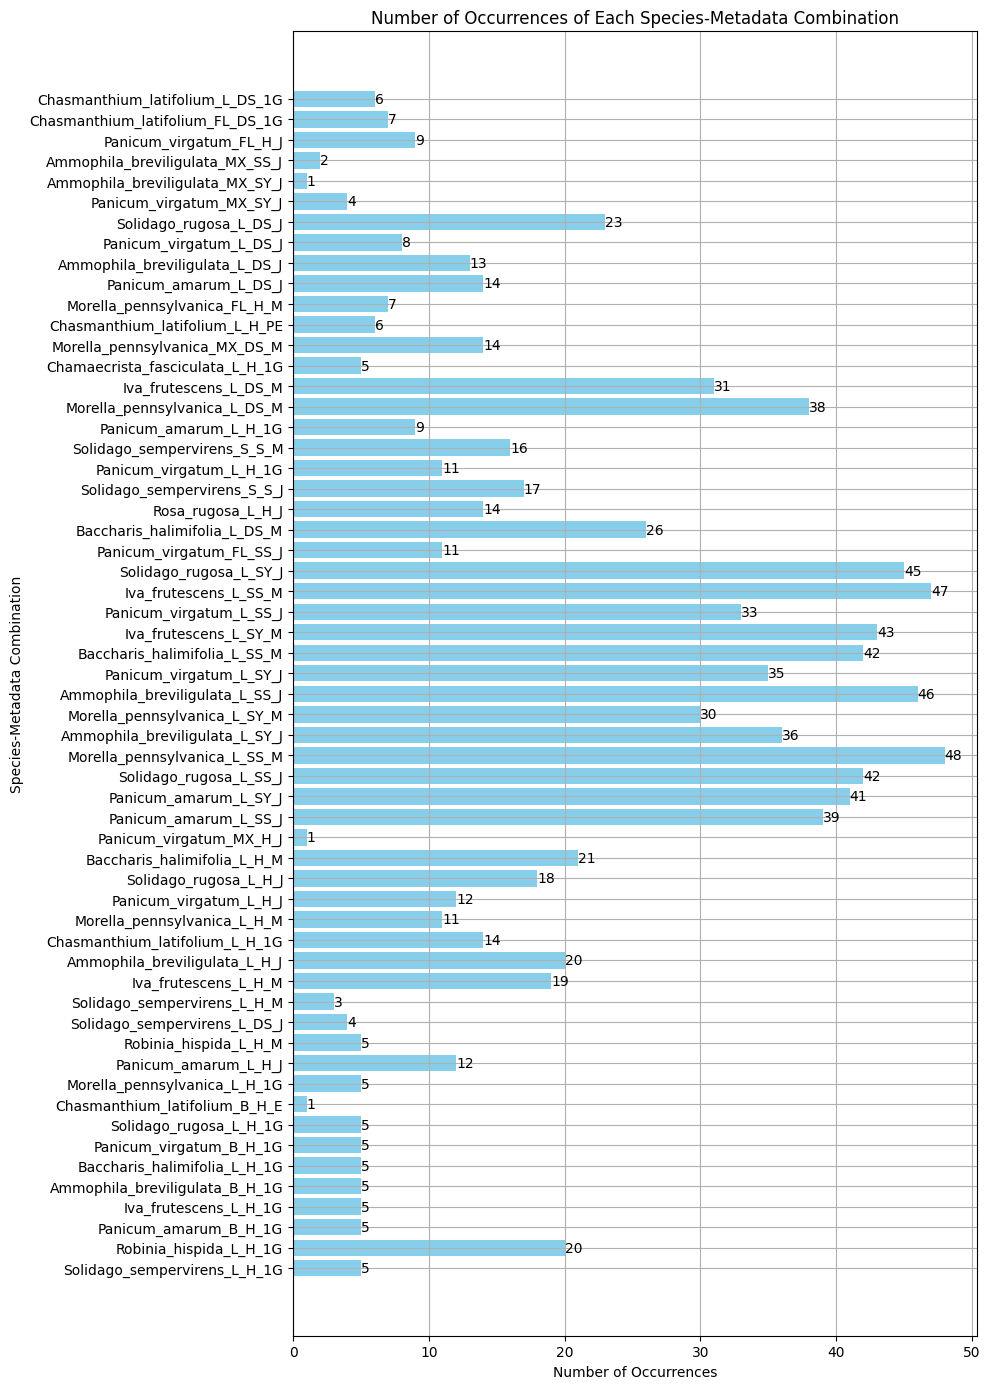

In [6]:
# Count the occurrences of each unique value
name_full_category_counts = Counter(name_full_category)
# Extract the labels and values
labels, values = zip(*name_full_category_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(10, 14))
bars = plt.barh(labels, values, color='skyblue')
plt.grid(True)
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species-Metadata Combination')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species-Metadata Combination')
plt.tight_layout()
plt.show()

In [7]:
# Set the fontsize and create a function to colot plots be a specific metadata category
def set_color(x, colormap_name = 'tab20'):
    # This function returns a dictionary of colors based on the input numpy x of metadata values
    # The default colormap is tab10 (tableau 10), but any named colormap can be used
    categories = np.unique(x)
    if colormap_name == 'custom':
        color_list = ['r','g','b','c','m','y','maroon','orange',
              'darkgreen','peru','navy','teal',
              'indigo','crimson','pink','slategrey',
              'darkgoldenrod','purple']
        clr = {}
        for i,category in enumerate(categories):
            clr[category] = color_list[i]
    else:
        clr = {}
        cmap = matplotlib.colormaps.get_cmap(colormap_name)
        for i,category in enumerate(categories):
            clr[category] = cmap(i/len(categories))
    return clr 

In [22]:
from collections import defaultdict

def plot_spectra_for_name_full_category_by_date(name_full_cat: str):
    selected_indices = np.where(name_full_category==name_full_cat)[0]
    #print(selected_indices)
    #print(DateTimeId[selected_indices])

    # Group DateTimeId based on the first 11 characters
    grouped_dates = defaultdict(list)
    for i, date_id in enumerate(DateTimeId[selected_indices]):
        group_key = date_id[:11]
        # Store the original index from selected_indices
        grouped_dates[group_key].append(selected_indices[i])

    # Sort the keys (date strings) chronologically
    sorted_keys = sorted(grouped_dates.keys())

    # Create a new dictionary with sorted keys
    sorted_grouped_dates = {key: grouped_dates[key] for key in sorted_keys}

    # Print the sorted grouped indices
    #for date_key, group in sorted_grouped_dates.items():
    #    print(f"Original Indices for group {date_key}: {group}")
    
    
    plt.figure(figsize=(14,10))
    plt.grid(True)

    clr = set_color(range(len(sorted_grouped_dates)), 'custom')


    for i, (group_name, group_indices) in enumerate(sorted_grouped_dates.items()):
        mean_spectrum = np.mean(spectra[group_indices,:], axis=0)
        plt.plot(wl, mean_spectrum, label=group_name, lw=1, c=clr[i])

    #for idx in selected_indices:
    #    plt.plot(wl, spectra[idx], label=DateTimeId[idx], lw=1, c=clr[DateTimeId[idx]])

    plt.xlabel('Wavelength')
    plt.ylabel('Refletance')
    plt.title(f'{name_full_cat} ({len(selected_indices)} Spectra)')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncols=3)

In [ ]:
# # Group DateTimeId based on the first 11 characters
# grouped_dates = defaultdict(list)
# for i, date_id in enumerate(DateTimeId[selected_indices]):
#   group_key = date_id[:11]
#   # Store the original index from selected_indices
#   grouped_dates[group_key].append(selected_indices[i])

# # Get the indices of each group
# group_indices = list(grouped_dates.values())

# print(group_indices)

# # Print the grouped indices (now containing original indices)
# for group in group_indices:
#   print(f"Original Indices for group {DateTimeId[group[0]][:11]}: {group}")


In [28]:
#print(len(sorted_grouped_dates))

8


545


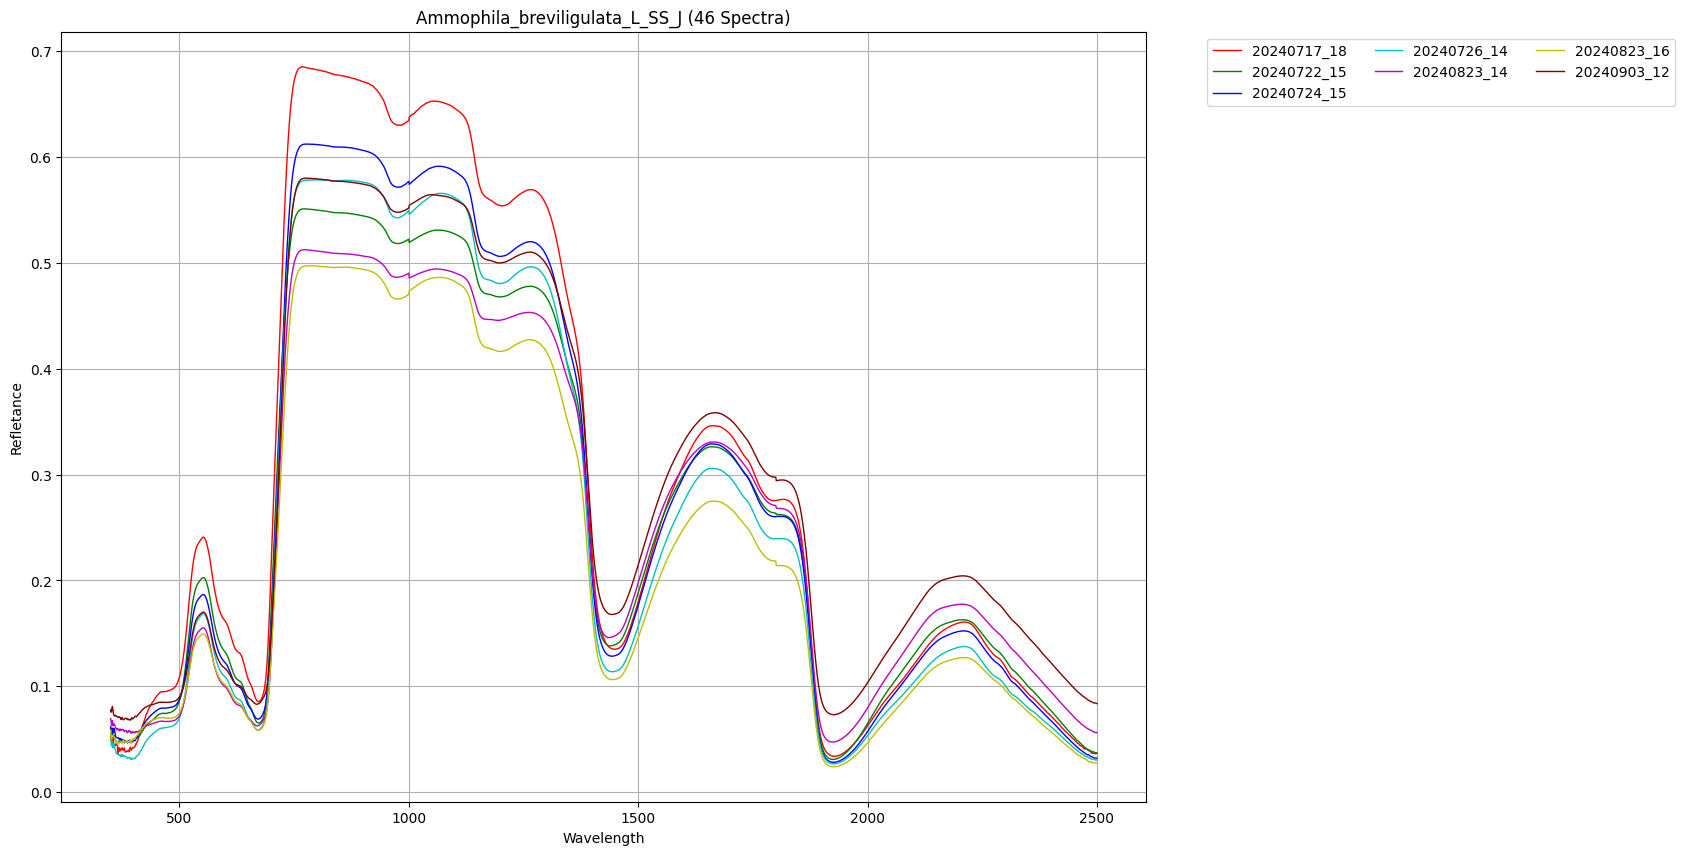

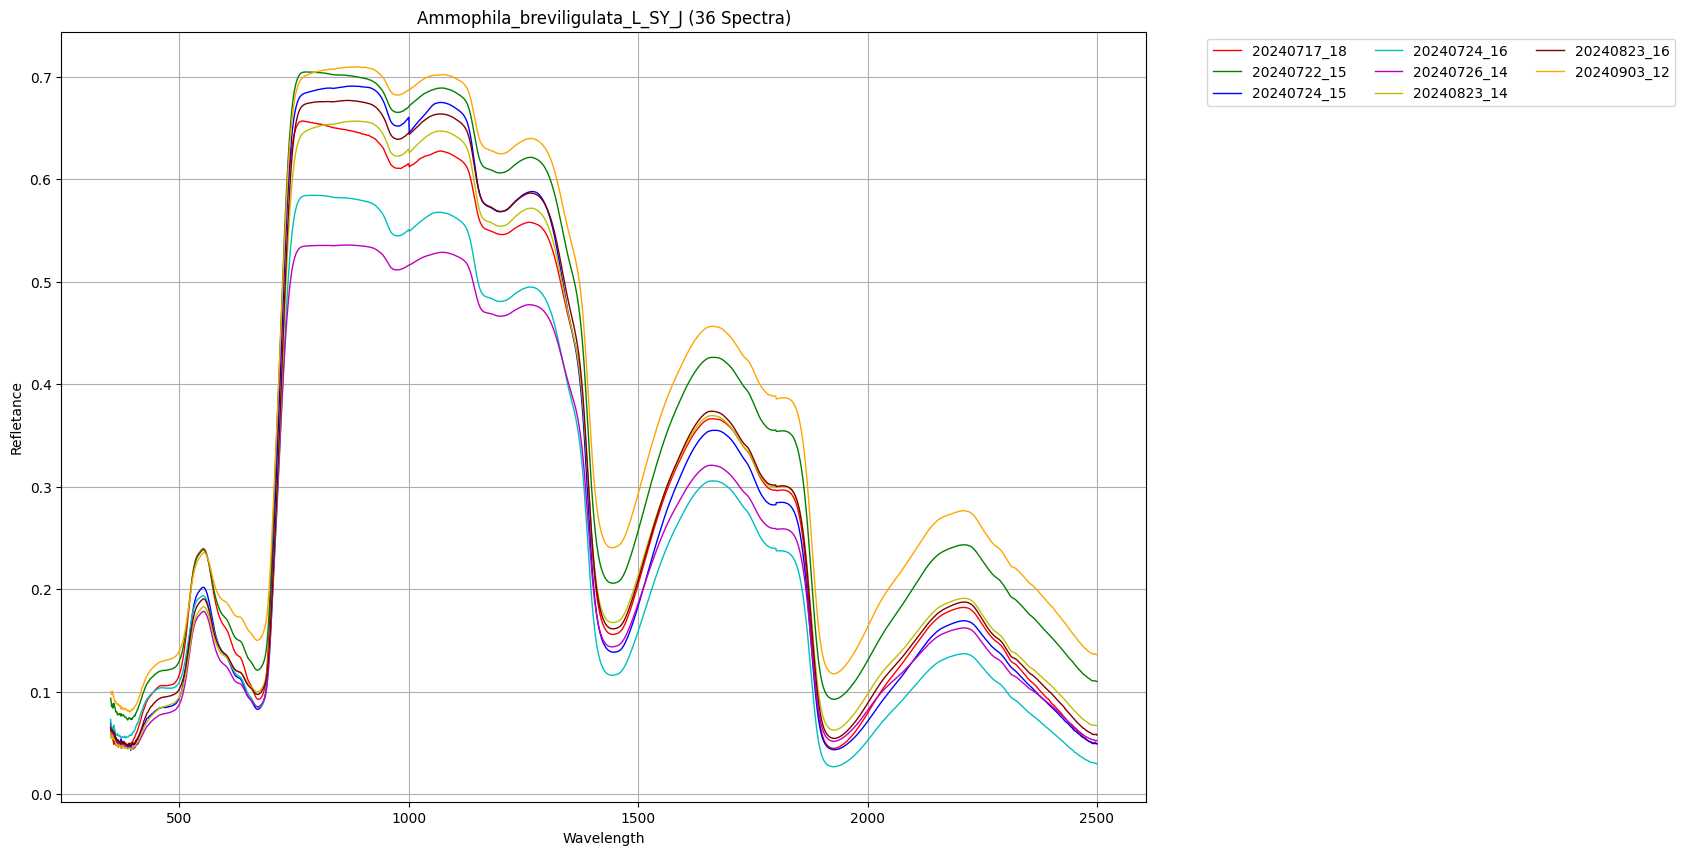

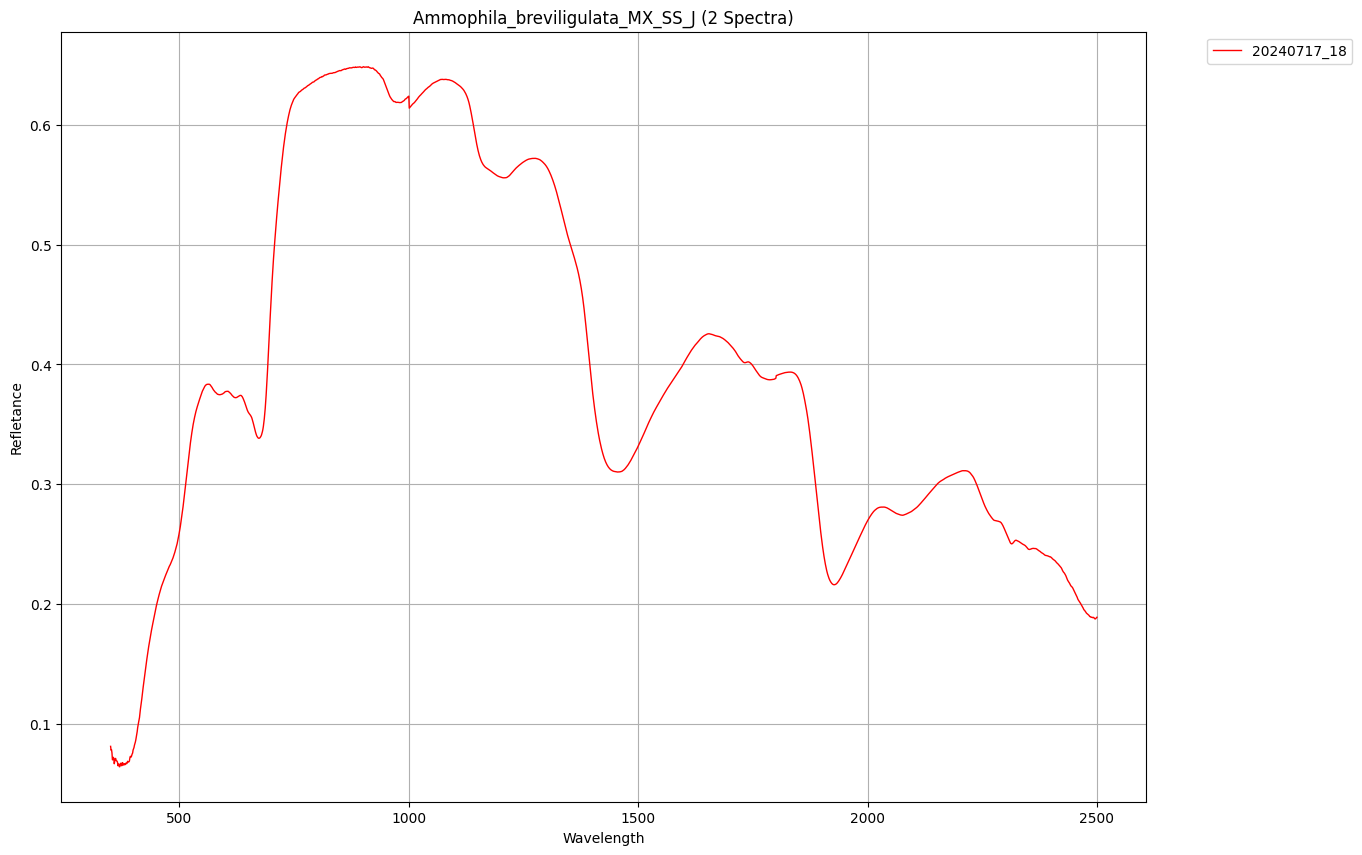

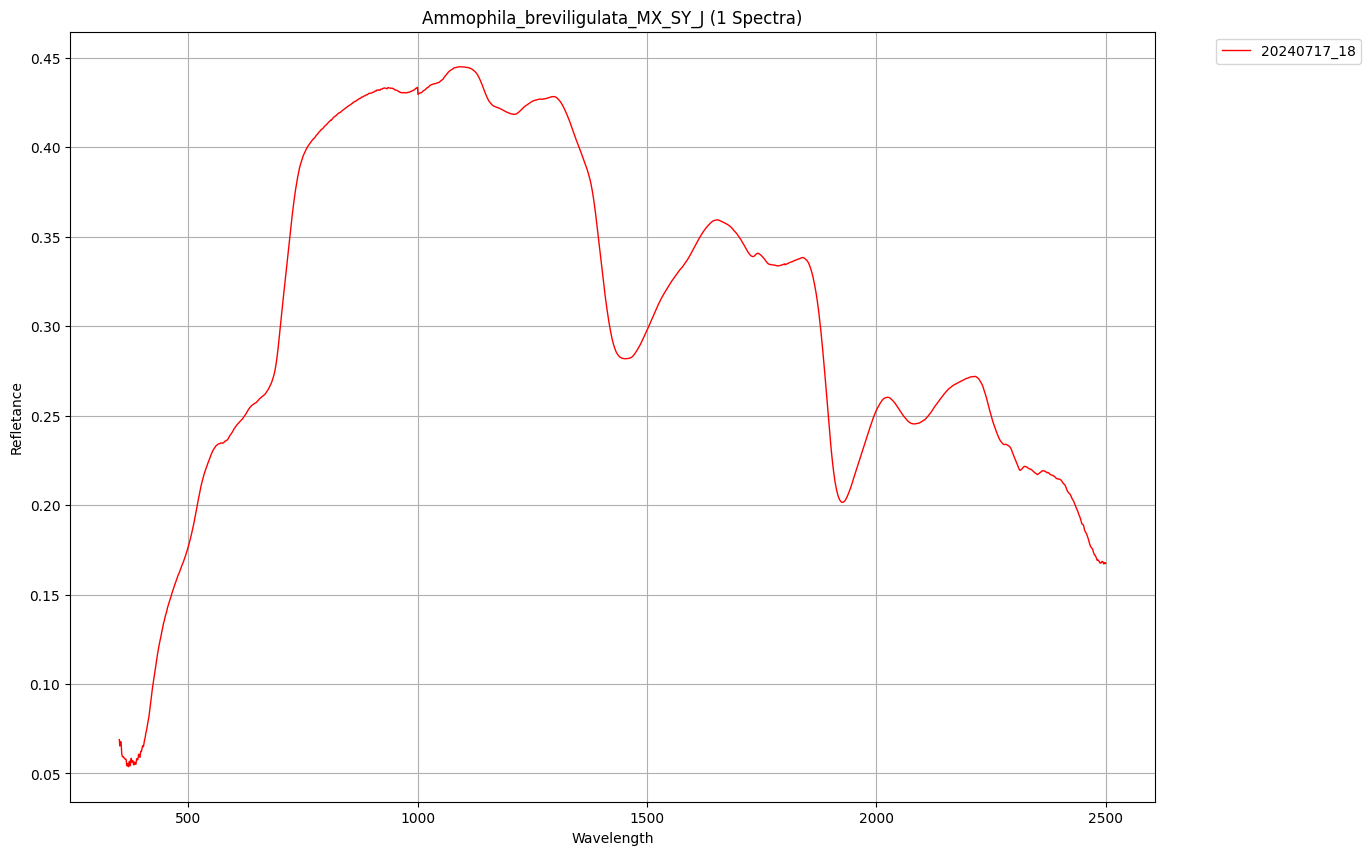

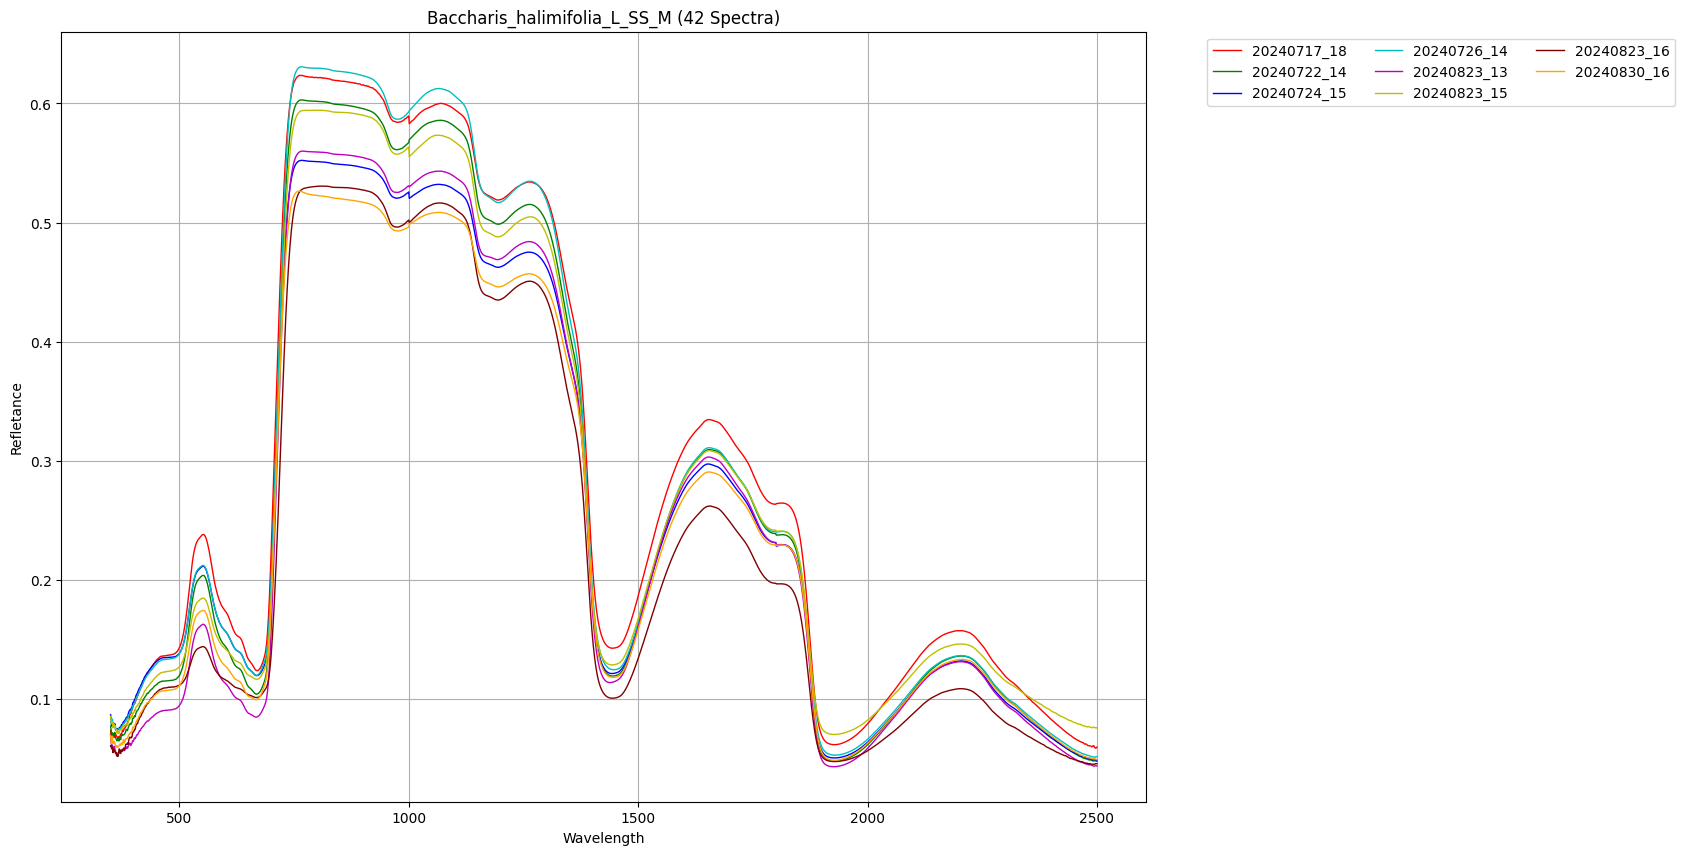

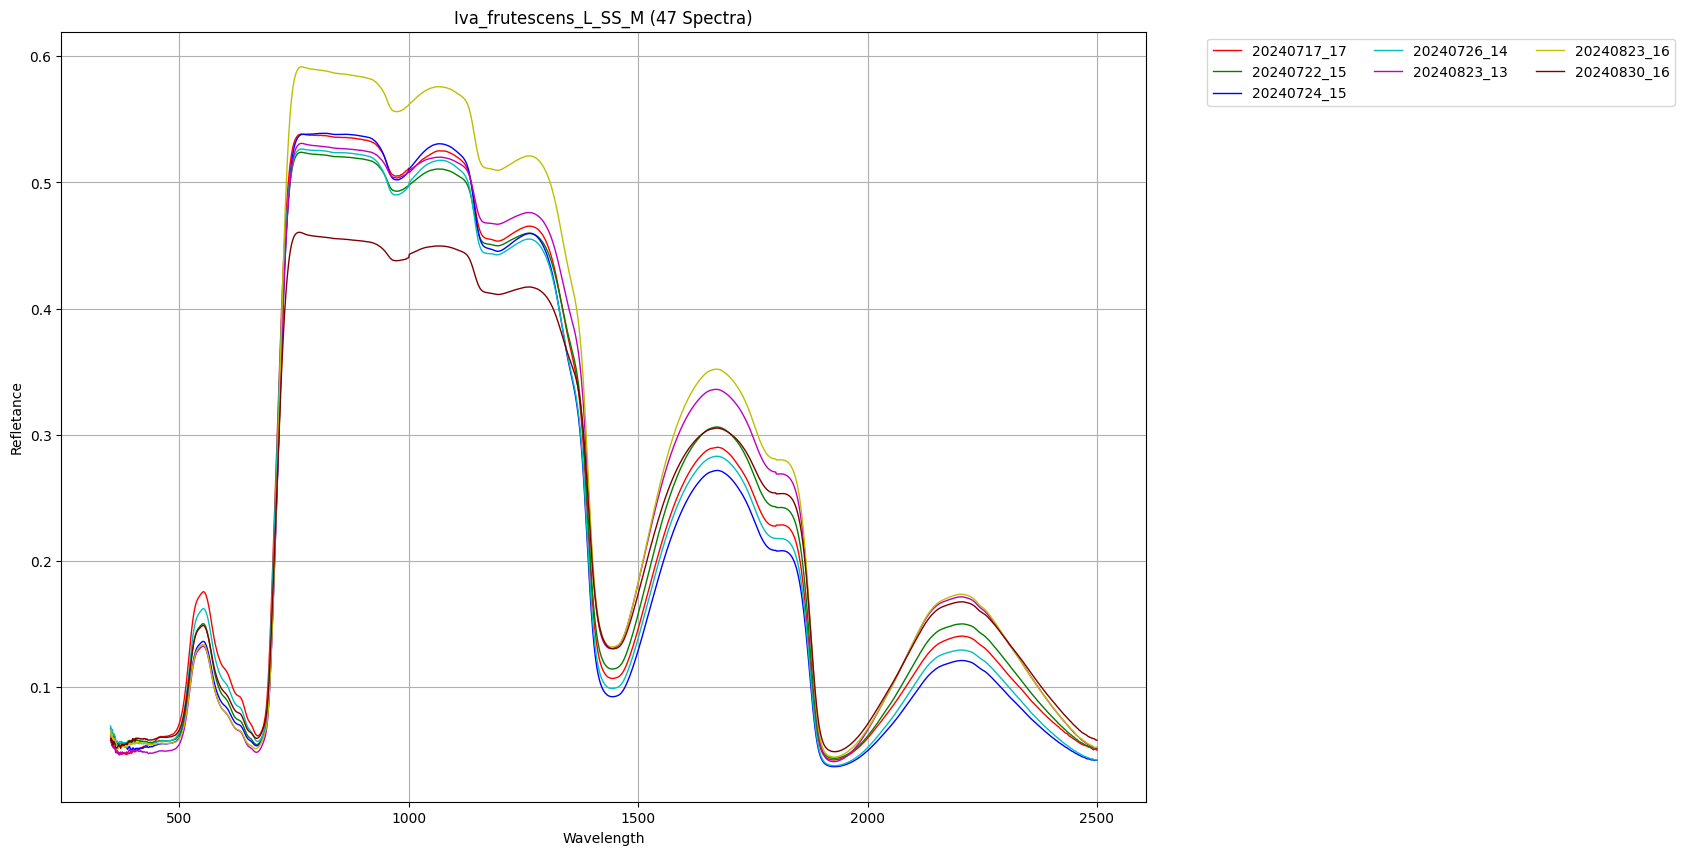

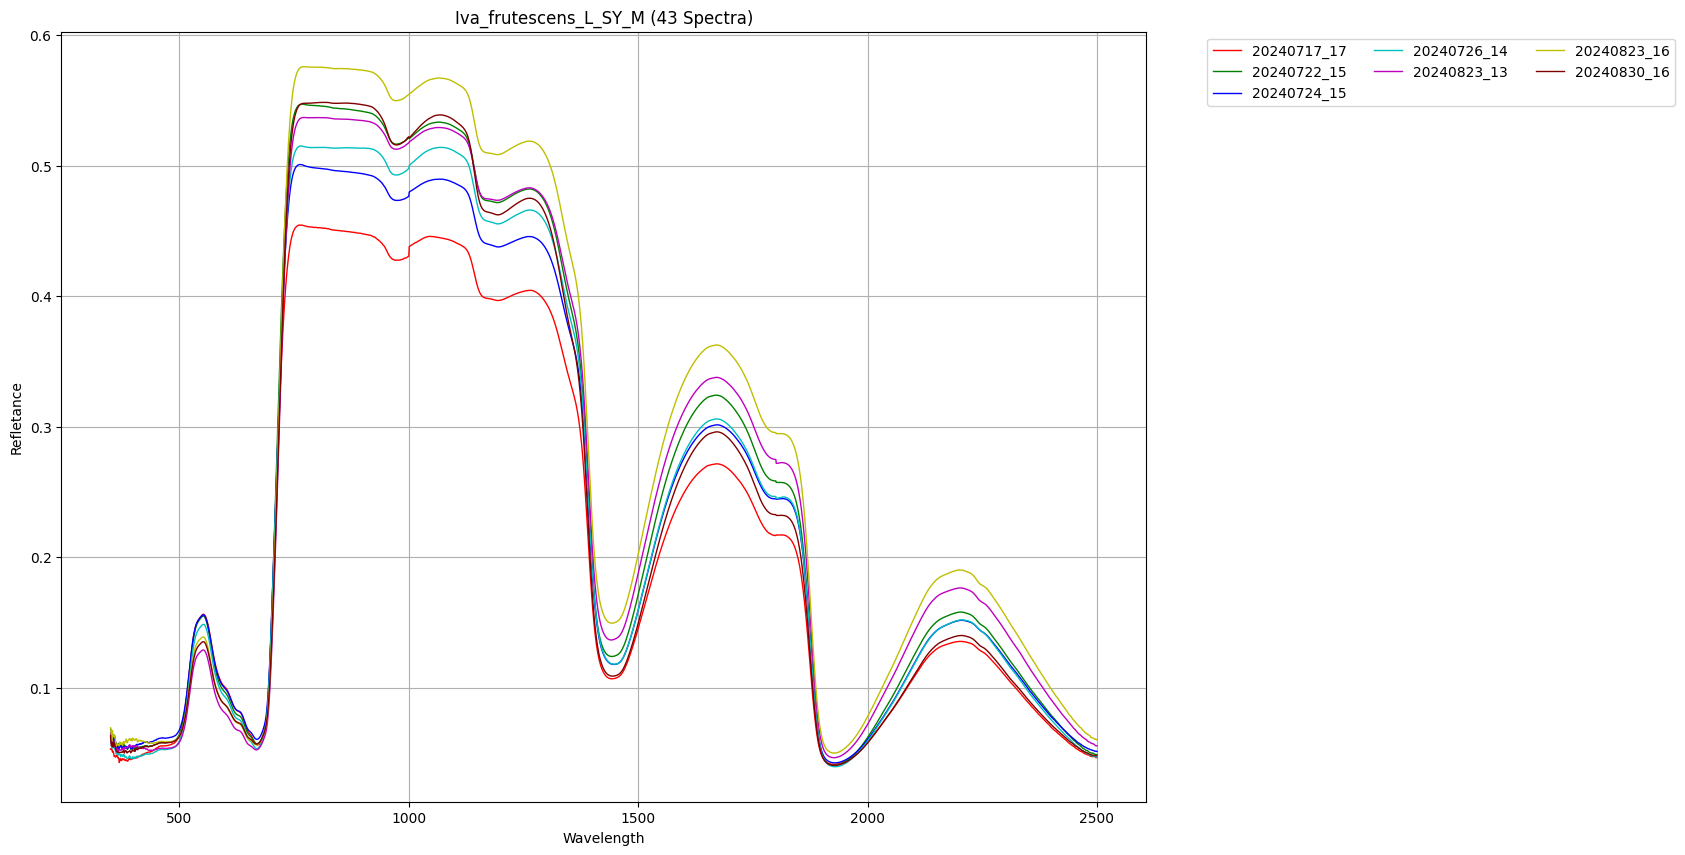

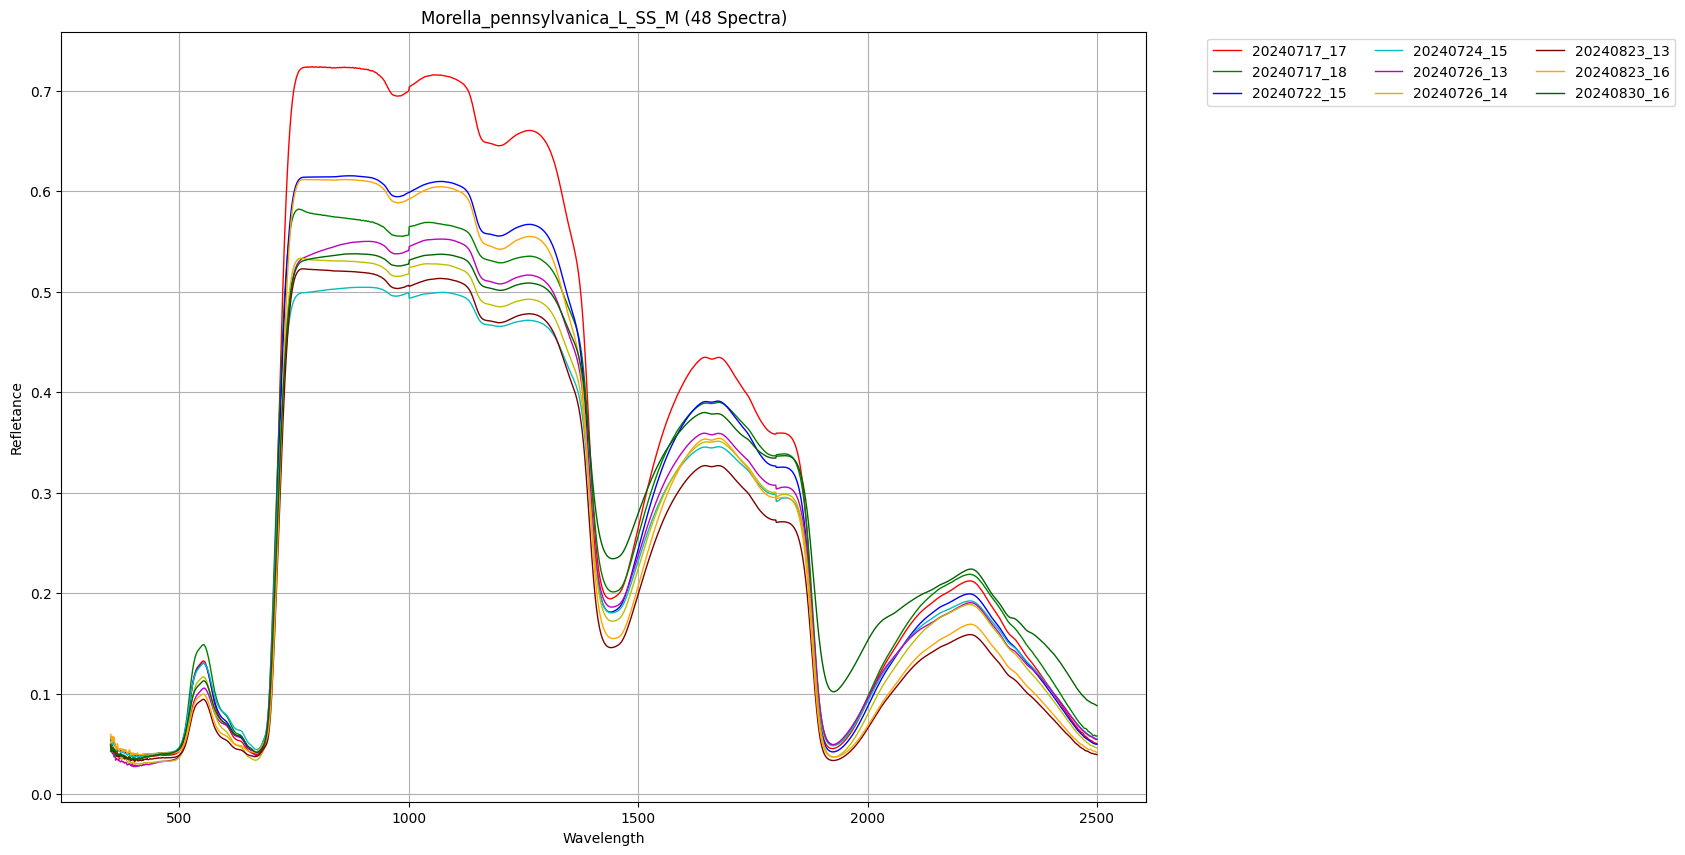

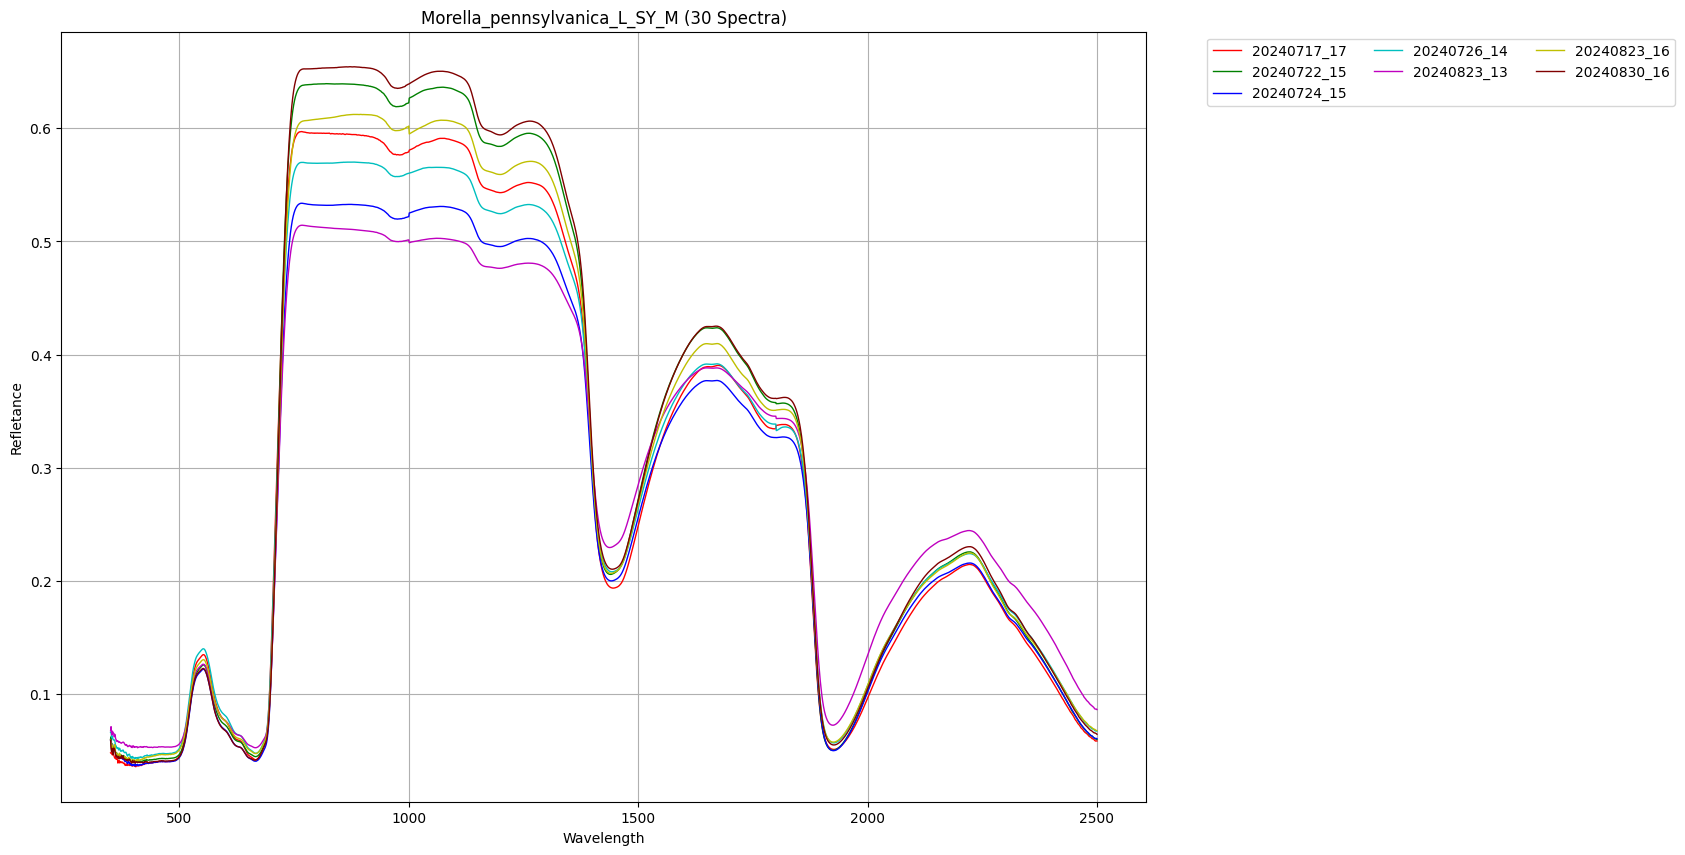

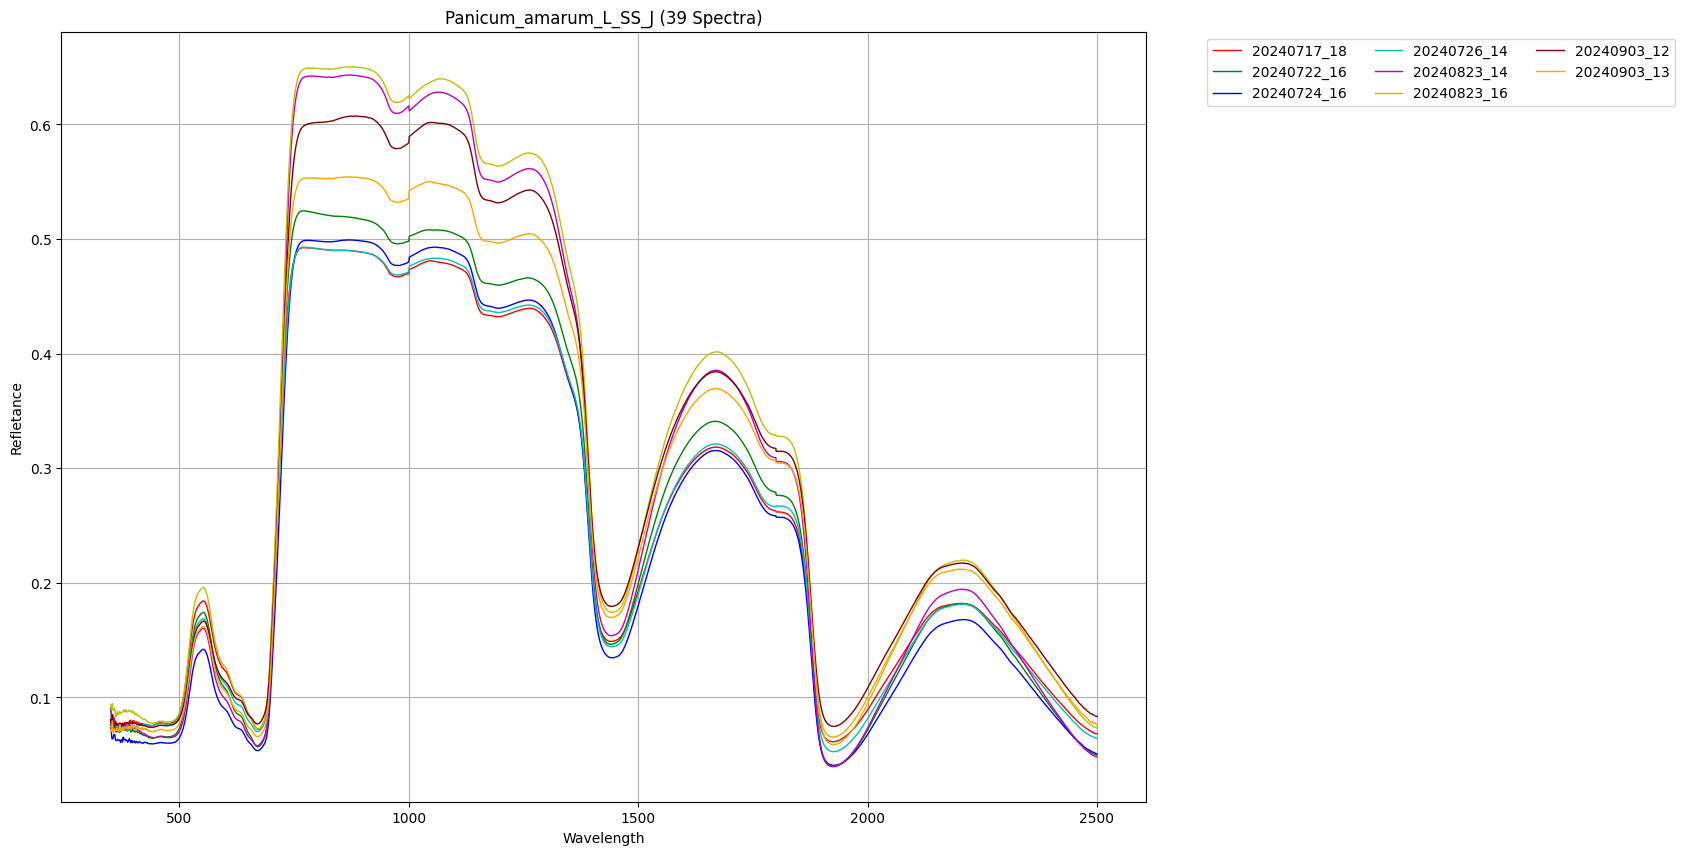

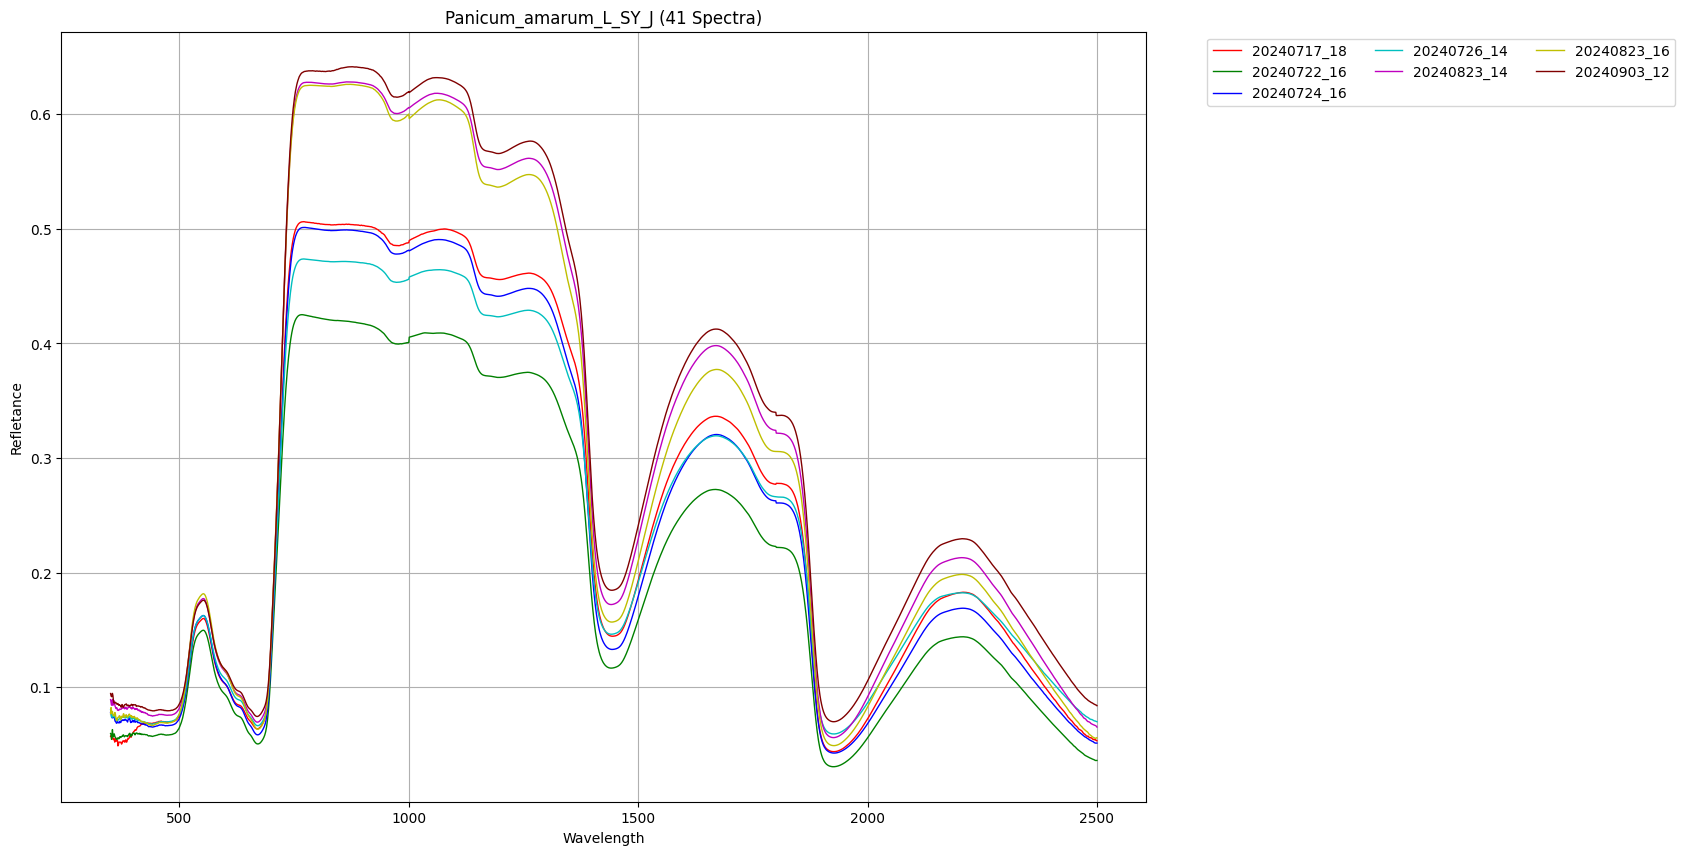

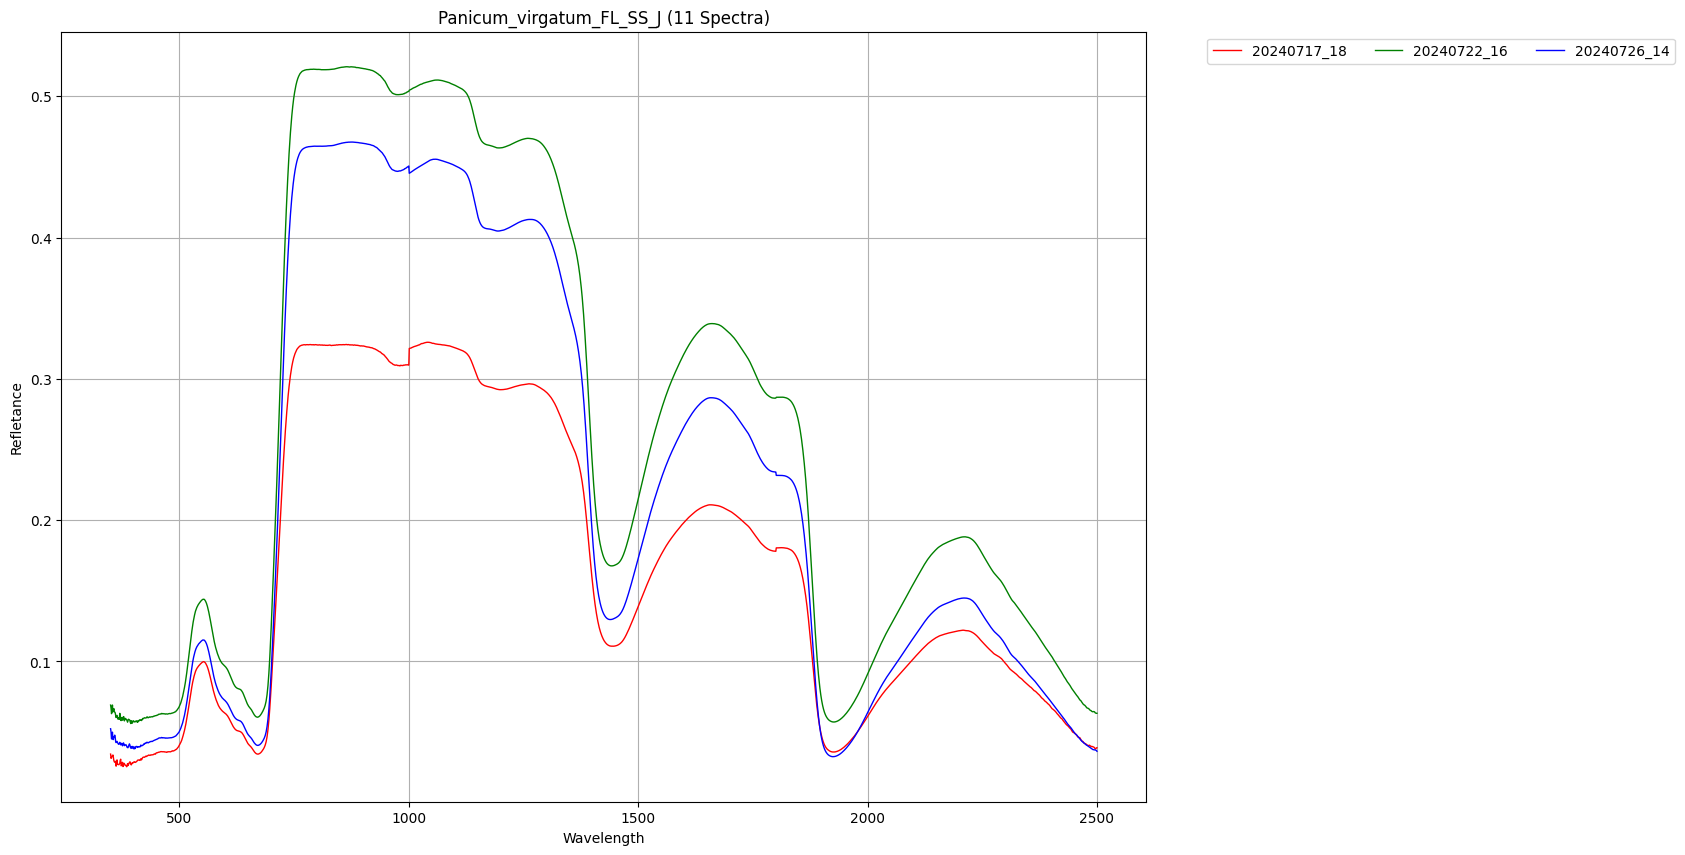

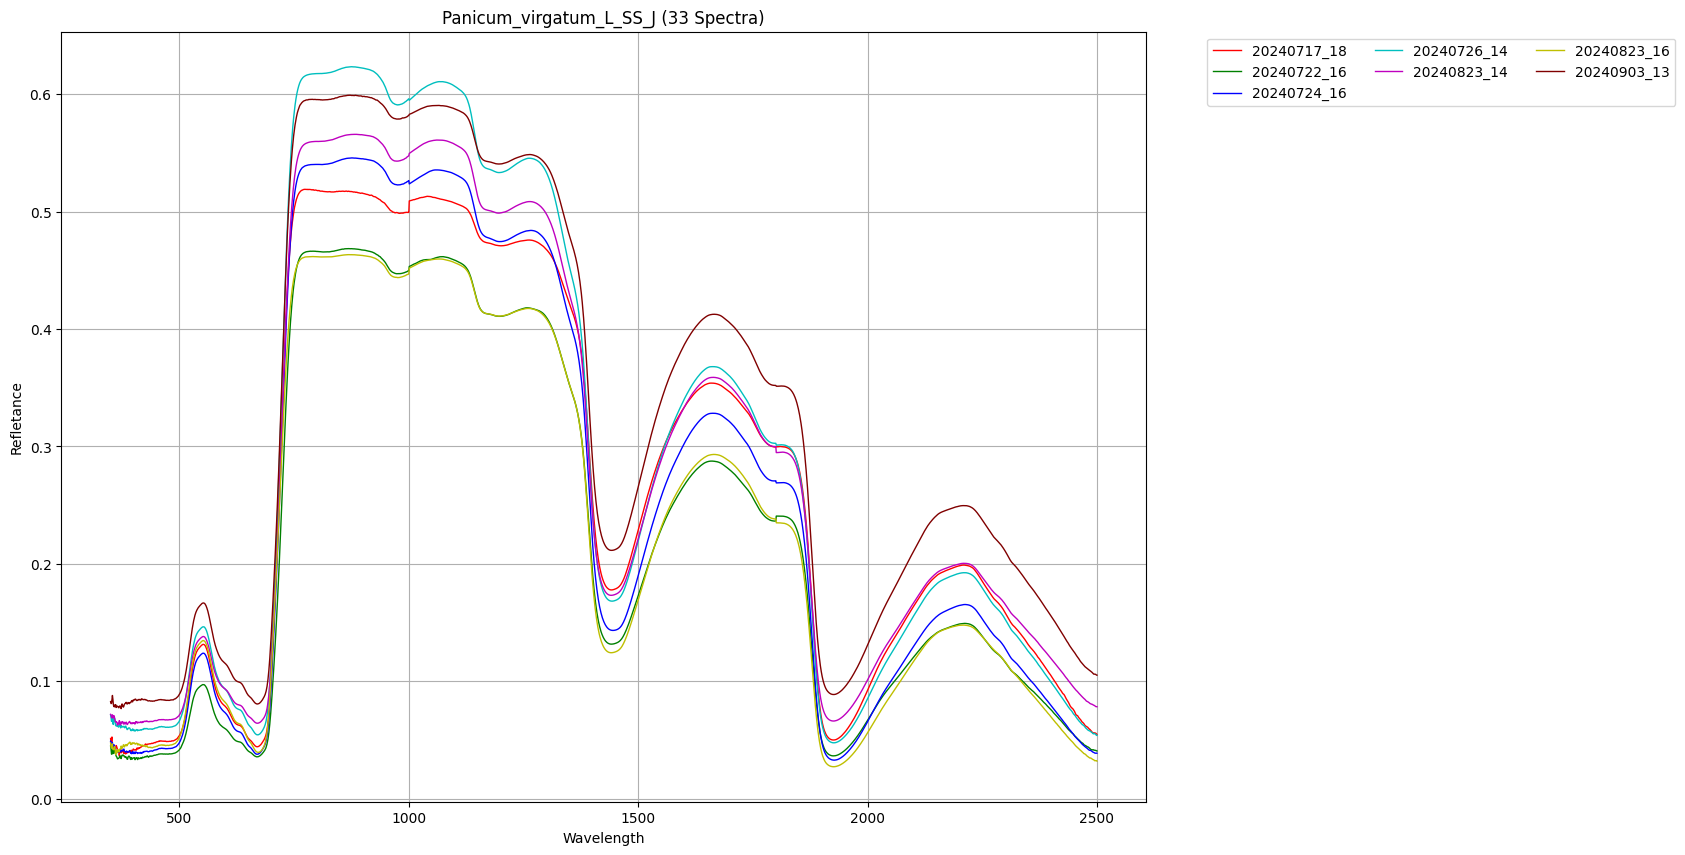

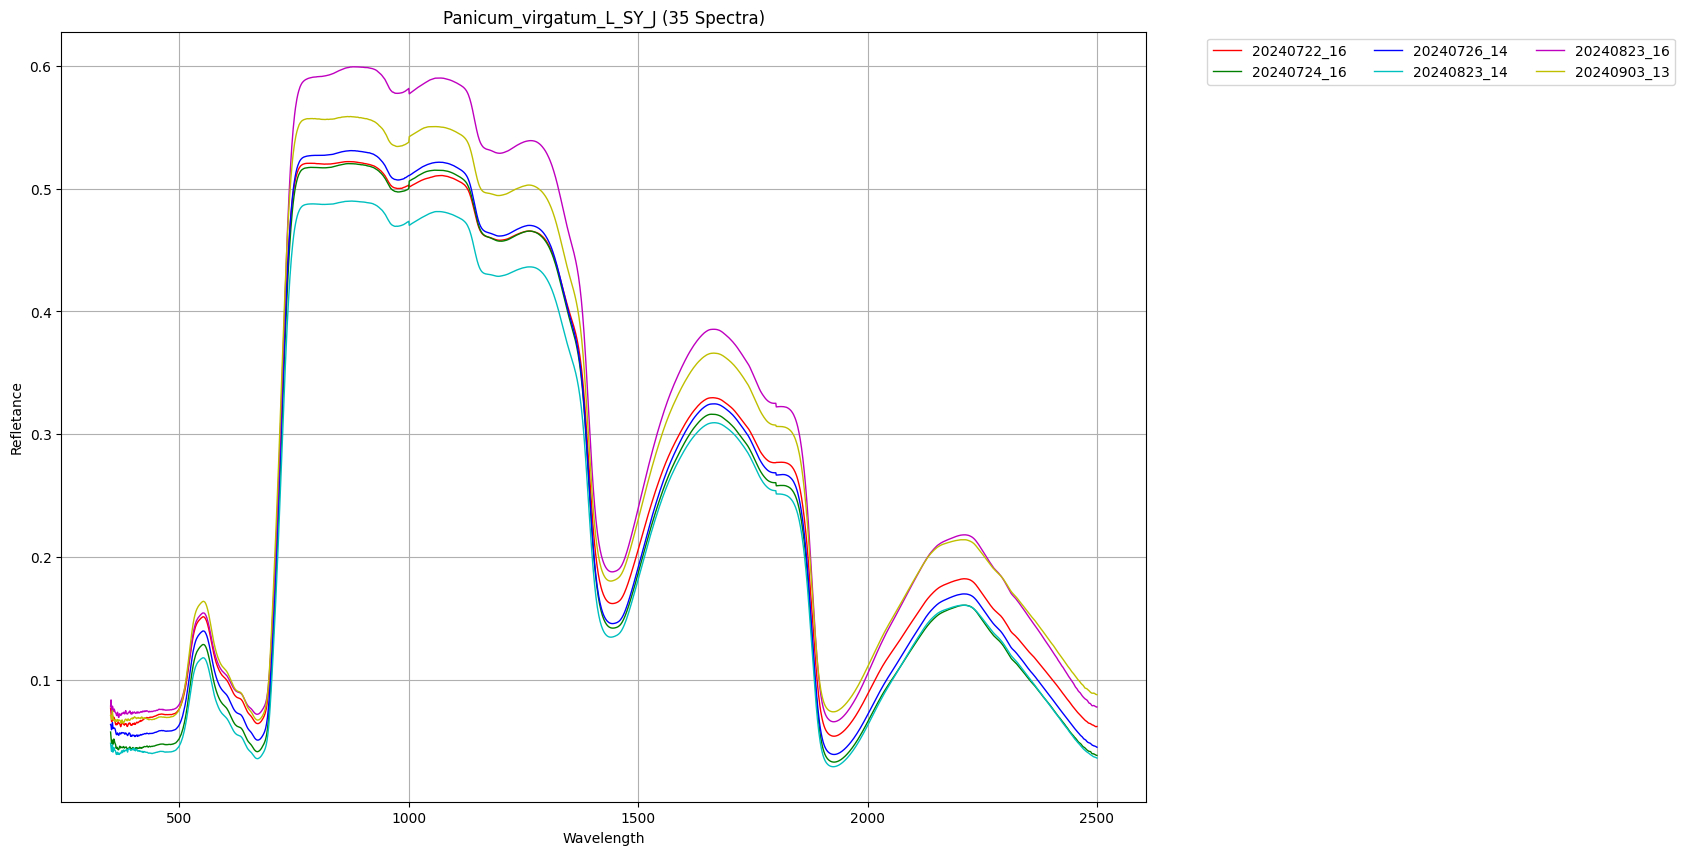

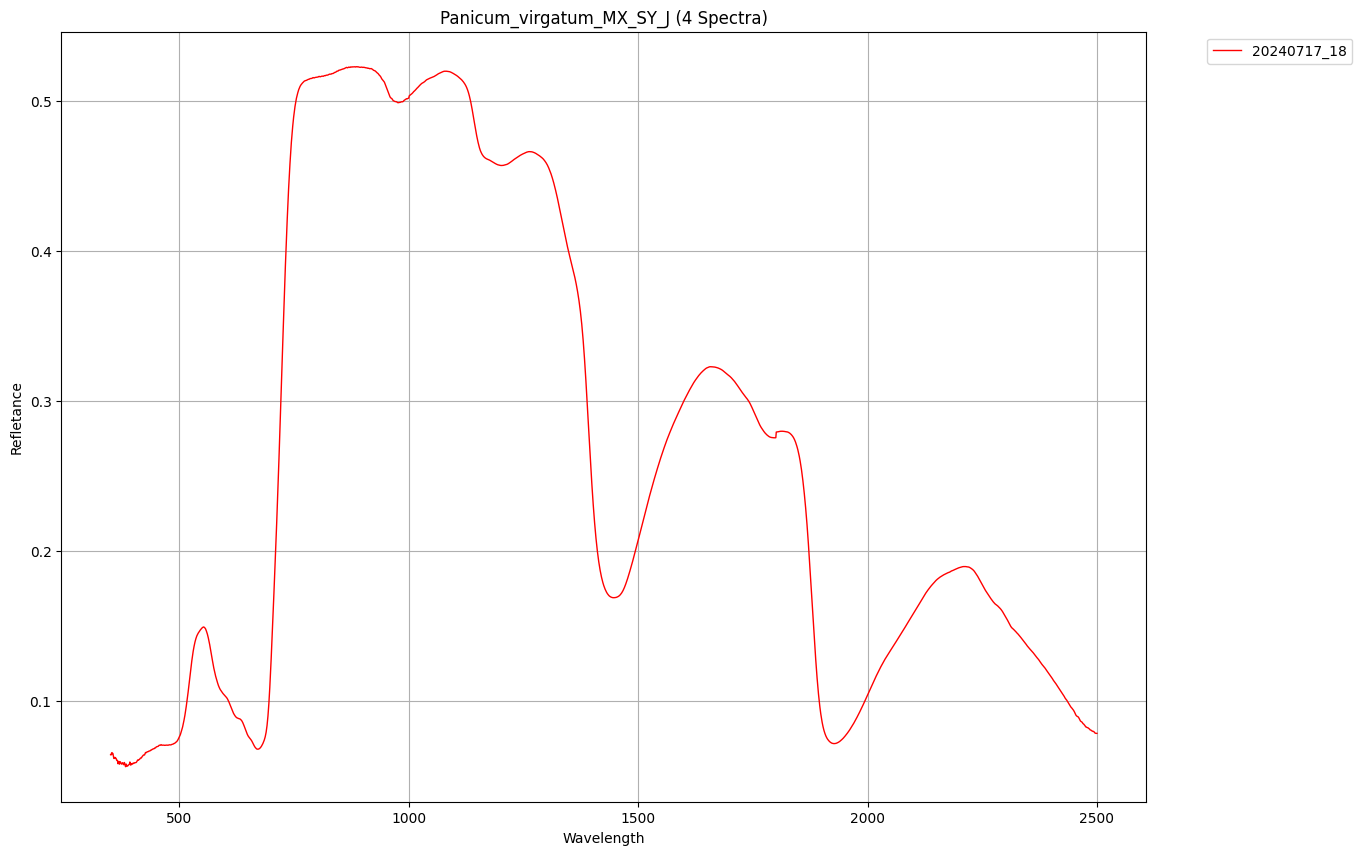

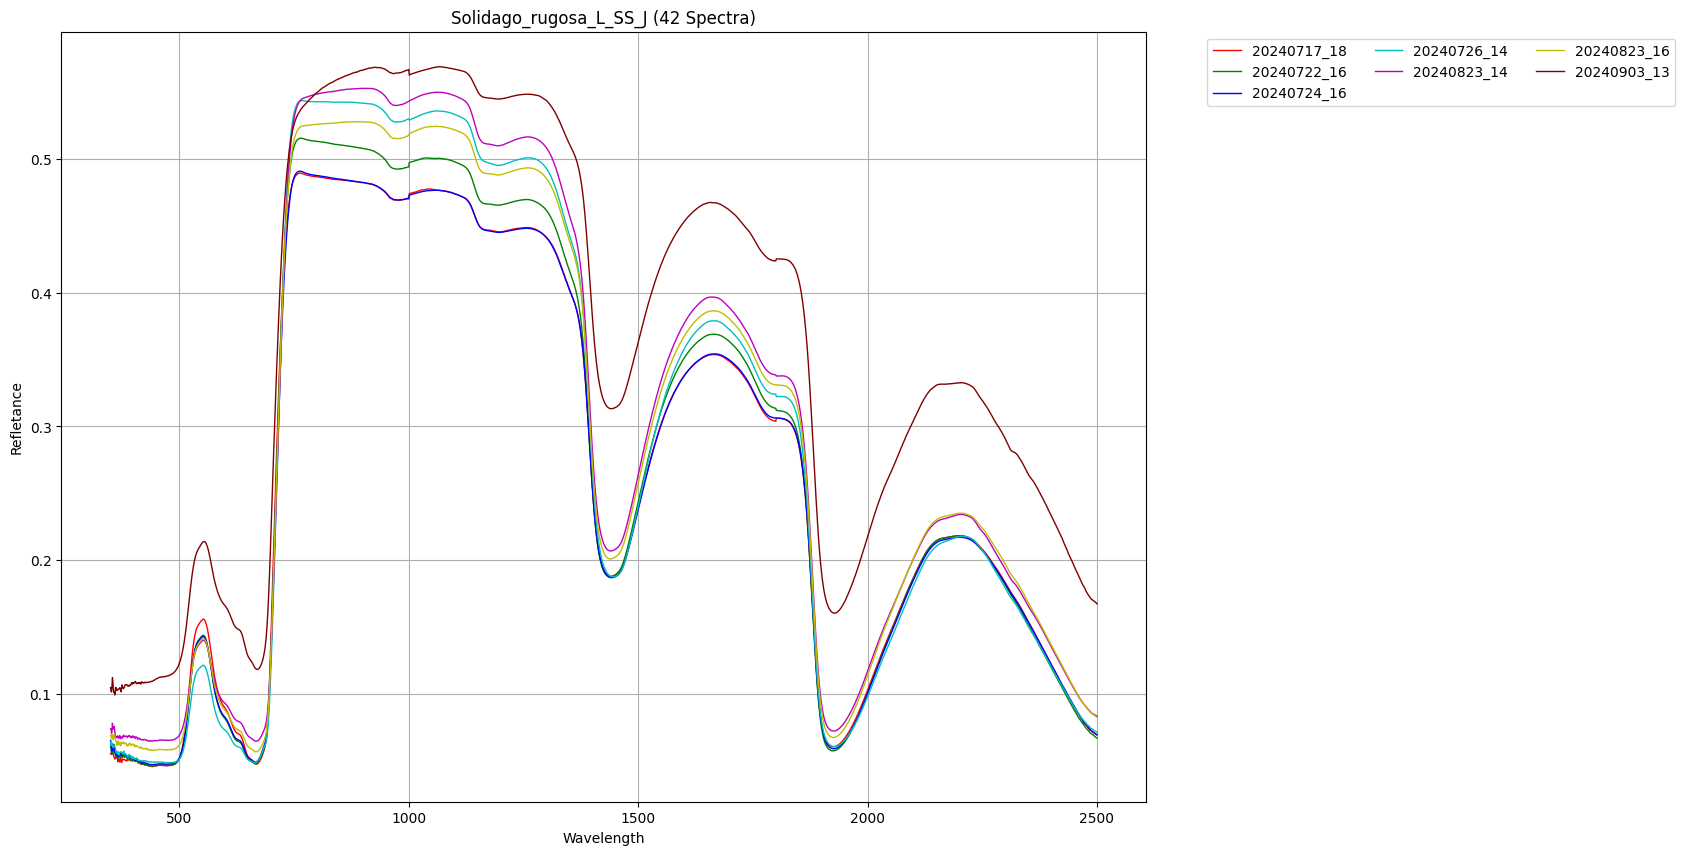

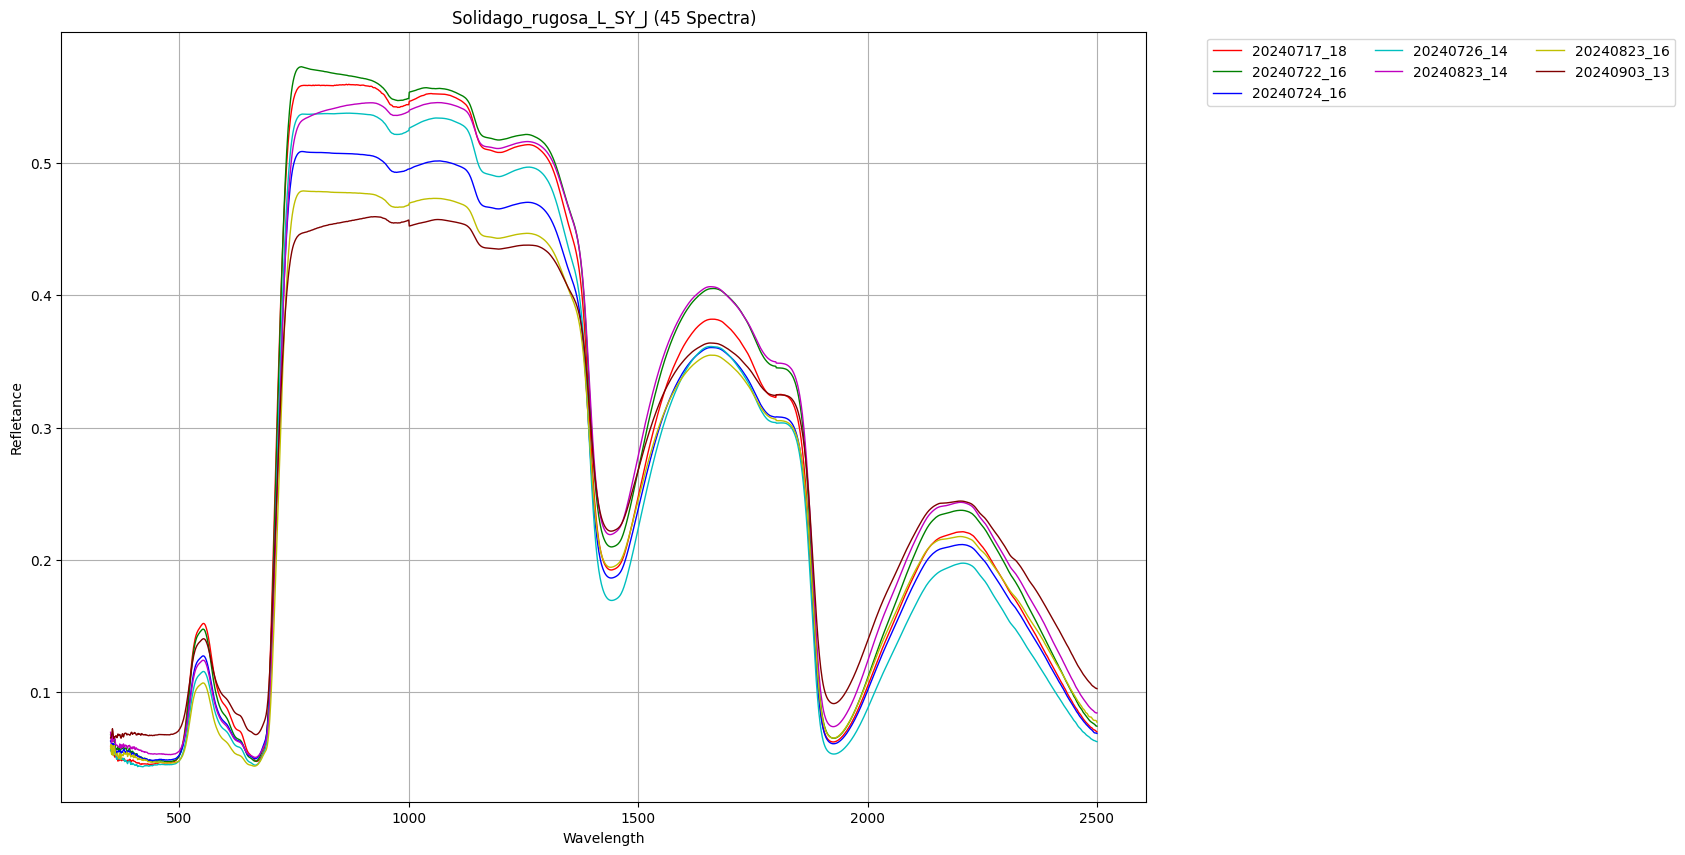

In [23]:
health_codes = ['SS', 'SY']
salt_stress_indices = np.where(np.isin(health, health_codes))[0]
print(len(salt_stress_indices))

#salt_stress_indices2 = health[(health == 'SS') | (health == 'SY')]
#print(len(salt_stress_indices2))

for n in np.unique(name_full_category[salt_stress_indices]):
    #print(n)
    plot_spectra_for_name_full_category_by_date(n)

#plot_spectra_for_full_category_by_date('Baccharis_halimifolia_L_SS_M')